# Identifying spam e-mails with machine learning

A common use for binary classification is sorting spam e-mails from legitimate e-mails. Machine-learning models that classify e-mails as spam or not spam typically use the [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) learning algorithm because it has proven to be effective at identifying spam, even with relatively small training sets. Let's build a Naive Bayes classification model and train it with 1,000 e-mails labeled with 0s (for not spam) and 1s (for spam) and then run a few e-mails through it to see how well it performs.

## Load and prepare the data

The first step is to load the dataset and prepare it for use in machine learning. Because machine-learning models can't deal with text, we'll use scikit-learn's [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class to vectorize the text in the training e-mails. Then we'll split the data for training and testing.

In [1]:
import pandas as pd

df = pd.read_csv('Data/ham-spam.csv')
df.head()

,IsSpam,Text
0,0,key issues going forwarda year end reviews rep...
1,0,congrats contratulations the execution the cen...
2,0,key issues going forwardall under control set...
3,0,epmi files protest entergy transcoattached our...
4,0,california power please contact kristin walsh ...


Find out how many rows the dataset contains and confirm that there are no missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   IsSpam  1000 non-null   int64 
 1   Text    1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Check for duplicate rows in the dataset.

In [3]:
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        500    499   paso firm capacity award memorandumlouise del...    2
1        500    500  you get your order immediately via gra levitr ...    1

The dataset contains one duplicate row. Let's remove it and check for balance.

In [4]:
df = df.drop_duplicates()
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499   brazil commercial update version delete previ...    1
1        500    500  you get your order immediately via gra levitr ...    1

Use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to vectorize the text in the DataFrame's "Text" column using a built-in dictionary of stop words.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
x = vectorizer.fit_transform(df['Text'])
y = df['IsSpam']

Show the vocabulary that `CountVectorizer` built from the training e-mails.

In [6]:
vectorizer.vocabulary_

{'key': 50036,
 'issues': 48310,
 'going': 40119,
 'forwarda': 37692,
 'year': 99702,
 'end': 31413,
 'reviews': 77698,
 'report': 76304,
 'needs': 60510,
 'generating': 39353,
 'like': 52433,
 'mid': 57723,
 'documenting': 27881,
 'business': 12428,
 'unit': 93760,
 'performance': 66771,
 'review': 77618,
 'completion': 18806,
 'david': 23666,
 'john': 49105,
 'work': 98732,
 'plan': 67886,
 'generation': 39362,
 'nim': 61313,
 'employees': 31202,
 'hpl': 44127,
 'transition': 92241,
 'ongoing': 63430,
 'officially': 63018,
 'transferred': 92194,
 'regardsdelainey': 75386,
 'key issues': 50047,
 'issues going': 48337,
 'going forwarda': 40142,
 'forwarda year': 37693,
 'year end': 99733,
 'end reviews': 31450,
 'reviews report': 77707,
 'report needs': 76342,
 'needs generating': 60519,
 'generating like': 39356,
 'like mid': 52526,
 'mid year': 57738,
 'year documenting': 99731,
 'documenting business': 27882,
 'business unit': 12542,
 'unit performance': 93775,
 'performance review'

In addition to creating sparse matrices of vectorized text, `Countvectorizer` converts text to lowercase, removes stop words and punctuation characters, and more. Let's see how it cleans text before vectorizing it by transforming a string, and then reversing the transform.

In [7]:
text = vectorizer.transform(['Why pay MORE for * expensive meds when you can ...123... order them online and save $$$?'])
text = vectorizer.inverse_transform(text)
print(text)

[array(['expensive', 'meds', 'online', 'order', 'order online', 'pay',
       'save'], dtype='<U401')]


Split the dataset so that 80% can be used for training and 20% for testing.

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)  

## Train a Naive Bayes classifier

The next step is to train a Naive Bayes classifier. We'll use scikit-learn's [MultinomialDB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier, which is ideal for datasets vectorized by `CountVectorizer`.

In [9]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

Validate the trained model with the 20% of the dataset aside for testing and show a confusion matrix.

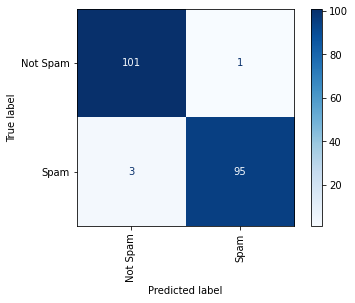

In [10]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, x_test, y_test, display_labels=['Not Spam', 'Spam'], cmap='Blues', xticks_rotation='vertical')

The model correctly identified 101 of 102 legitimate e-mails as not spam, and 95 of 98 spam e-mails as spam. Use the `score` method to get a rough measure of the model's accuracy.

In [11]:
model.score(x_test, y_test)

0.98

Now retrieve the Receiver Operating Characteristic (ROC) metric for a better measure of accuracy.

In [12]:
from sklearn.metrics import roc_auc_score

probabilities = model.predict_proba(x_test)
roc_auc_score(y_test, probabilities[:, 1])

0.9992997198879552

## Use the model to classify e-mails

Now let's see how the model classifies some sample e-mails. We'll start with a message that is not spam. The model's `predict` method predicts a class: 0 for not spam, or 1 for spam.

In [13]:
message = vectorizer.transform(['Can you attend a code review on Tuesday? Need to make sure the logic is rock solid.'])
model.predict(message)[0]

0

What is the probability that the message is not spam? We can get that by calling `predict_proba`, which returns an array containing two values: the probability that the predicted class is 0, and the probability that the predicted class is 1, in that order.

In [14]:
model.predict_proba(message)[0][0]

0.9999170457201042

Now test the model with a spam message.

In [15]:
message = vectorizer.transform(['Why pay more for expensive meds when you can order them online and save $$$?'])
model.predict(message)[0]

1

What is the probability that the message is not spam?

In [16]:
model.predict_proba(message)[0][0]

0.00021423891260677753

What is the probability that the message IS spam?

In [17]:
model.predict_proba(message)[0][1]

0.9997857610873945

Observe that `predict` and `predict_proba` accept an array of inputs. Based on that, could you classify an entire batch of e-mails with one call to `predict` or `predict_proba`? How would you get the results for each e-mail?